# Scientific concepts project report

## The problem

In scientific community it is important to updated about recent works and concepts, that are the **State-of-the-art** now. As more and more papers getting published every day, it is hard to follow all of them even in particular area of interest. With this project we want to provide the academic researcher with personilized list of scientific concepts studying of which would enhance their research capabilities. 

**Model user** is an academic researcher in the field of biomedicine. Said person has
some prior (domain) knowledge that I consider as a set of concepts that person selfclaim to be comfortable with. 

**Major assumption** that I make is that "scientific concepts studying of which would
enhance their research capabilities" are the ones that respective community of
researches deems important, while notion of importance can be deduced in the form of
numeric score, based on what they (researchers) write in scientific publications. 

## The data

The data for this project is taken from **Semantic Scholar Open Research Corpus**. Semantic Scholar is an open scientific paper search engine that connects relevant papers and extract useful information like abstracts, figures and entities of the paper. Since 2018 it includes more than 40 million papers on Biomedicine, Neuroscience and Computer Science. The data is avalible for downloading by [public API](https://api.semanticscholar.org/corpus/). 

The data is provided in JSON format with such fields: 
* id
* title
* paperAbstract
* entities
* s2Url
* s2PdfUrl
* pdfUrls
* authors
* inCitations
* outCitations
* year
* venue
* journalName
* journalVolume
* journalPages
* sources
* doi
* doiUrl
* pmid

For this project we use: **id**, **title**, **paperAbstract**, **entities** and **year** fields. 

## Preliminary steps recap

In order to execute code presented in this report, all (!) preliminary steps listed in readme.md required to be completed first. 

### Installed and configured

* Java 8
* Hadoop 3.1.2
* Spark 2.4.3 (Pre-built with user-provided Apache Hadoop)
* Python 3.6.8

As well as Python libraries listed under **requirements.txt**

### Downloaded

* Semantic Scholar Open Research Corpus
* FastText pretrained model

### HDFS and Yarn

* Name-nodes formatted
* Daemons started (start-dfs.sh, start-yarn.sh)
* Data converted to parquet and pushed to HDFS under scholar_data/base.parquet

**Note**: you will need daemons up and running while executing code in this notebook.

### Get data

#### If you have done the preliminary steps you can skip this part (you should have parque data saved) .

Download by running from project folder (creates data/ subfolder and stores there):
```
sh bash/get_data.sh
```

Or by following instructions on the website. In later case, make sure to remove sample file sample-S2-records.gz in order to avoid data duplication.

Now you can convert data from set of compressed jsons to parquet and store to HDFS. This is by far the most time consuming step, may take several hours to complete. On the bright side, due to to conversion, all consequent operations become rather fast.
```
python src/0_convert_to_parquet_store_to_hdfs.py
```

The **0_convert_to_parquet_store_to_hdfs.py** file selects 'id', 'title', 'year', 'entities', 'paperAbstract' fields and converts data to spark.sql parquet format optimized to work with big table data on pyspark. 

## Setup

### Libraries

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find() # solely to check whether path is correct

'/usr/local/spark/spark-2.4.3-bin-without-hadoop'

In [2]:
from pyspark.sql import SparkSession
from pyspark import SQLContext

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq

In [4]:
import os
import fasttext
import numpy as np
import pandas as pd
import statsmodels.api as sm
from rake_nltk import Rake
from tqdm import tqdm_notebook as tqdm

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline

### Global variables

In [6]:
dirpath = os.getcwd()
model_bin_path = f'{dirpath}/fasttext/crawl-300d-2M-subword.bin'

In [7]:
preprocess_data = True  # change to False, if you want to rerun all cells for demo, but have made preprocessing already
forecast_data = True    # change to False, if you want to rerun all cells for demo, but have made forecast already
rake_preprocess_data = True
rake_forecast_data = True

### Functions

In [8]:
def pivot_keyterms(df):
    # year - single integer, entities - list of strings (keyterms)
    # keep only papers for periods (years) that fully passed
    # make separate row for each keyterm
    df = df.select('year', 'entities').\
        filter("year < 2019").\
        withColumn('entities', F.explode('entities'))
    
    # turn all keyterms to lowercase
    df = df.withColumn('entities', F.lower(F.col('entities')))
    
    # cut number formatting: 10,000 -> 10000
    df = df.withColumn('entities', F.regexp_replace(F.col('entities'), '(\d)[, ](\d{3})', '$1$2'))
    
    # treat comma separated values as a different keyterms (even though they were posed as a unit)
    df = df.withColumn('entities', F.explode(F.split('entities', '[,]')))
    
    # substitute underscore with a space as a means of separation
    # get rid of excessive spaces
    df = df.withColumn('entities', F.regexp_replace(F.col('entities'), '_', ' '))
    df = df.withColumn('entities', F.trim(F.col('entities')))
    df = df.withColumn('entities', F.regexp_replace(F.col('entities'), '\s+', ' '))

    # keep only keyterms that contain alpha-numeric values and spaces
    # retrieve counts for each keyterm for each year
    # \w also includes uderscore, but we handled it earlier
    df = df.filter(~(F.col('entities').rlike('[^\w\s]'))).\
        groupby('entities').\
        pivot('year').\
        count().\
        sort('entities')
    
    return df

In [9]:
def get_tokens_frequency(df, token_min_length=3, token_min_count=11, enhance_factor=100000.0):
    # discard suspiciously short tokens 
    df = df.filter(f'LENGTH(entities) >= {token_min_length}')

    # gather column names linked to years
    col_years = [col_name for col_name in df.columns]
    col_years.remove('entities')

    # Find peak usage of token across the years
    # https://stackoverflow.com/questions/40874657/pyspark-compute-row-maximum-of-the-subset-of-columns-and-add-to-an-exisiting-da
    minf = F.lit(float("-inf"))
    df = df.withColumn("year_max", F.greatest(*[F.coalesce(F.col(year), minf) for year in col_years]))

    # forget about tokens that have never been really used
    df = df.filter(f'year_max >= {token_min_count}').drop('year_max')

    # find total number of "valid" tokens used on each year
    df = df.join(df.groupby().sum(*col_years))

    # retrieve token frequency (times common coefficient) for each year
    # coefficient is to make sure we do not limitations of float precision too hard
    for year in col_years:
        df = df.withColumn(year, enhance_factor*F.col(year) / F.col(f'sum({year})')).drop(f'sum({year})')
    
    return df 

In [10]:
def get_embeddings(pd_df, emb_length=300):
    # retrieve embeding for each keyterm
    model = fasttext.load_model(model_bin_path)
    pd_df['embeddings'] = pd_df['entities'].apply(model.__getitem__)
    del model

    # append embeddings as another column to the data frame 
    emb_components = pd.DataFrame(pd_df['embeddings'].tolist(), columns=[f'v{i}' for i in range(emb_length)])
    pd_df['embeddings'] = pd_df['embeddings'].apply(lambda x: list(x))
    pd_df = pd.concat([pd_df[:], emb_components[:]], axis=1) 
    return pd_df

In [11]:
def fit_lsh_model(df, seed=42, bucketLength=12.0, numHashTables=20):
    def make_normed_vector(x):
        # make L2-norm of the vector to be unit
        x_np = np.array(x, dtype=np.float64)
        x_np = x_np / np.linalg.norm(x_np)
        return Vectors.dense(x_np)
    
    df = df.select('entities', 'embeddings')

    to_vector = F.udf(lambda x: Vectors.dense(x), VectorUDT())
    to_normed_vector = F.udf(make_normed_vector, VectorUDT())

    df = df.withColumn('normed_embeddings', to_normed_vector('embeddings'))
    df = df.withColumn('embeddings', to_vector('embeddings'))

    # even though method is designed for Euclidean distances, we can use it for cosine distances, as done here
    # to do so, we normalize input vectors first, then Euclidean distance is nothing else, but sqrt(2)*sqrt(cosine_distance), and sqrt is a monotone transformation
    brpLSH = BucketedRandomProjectionLSH(inputCol="normed_embeddings", outputCol="hashes", seed=seed, bucketLength=bucketLength, numHashTables=numHashTables)
    brpLSHmodel = brpLSH.fit(df)

    return brpLSHmodel, df

In [12]:
def norm_np_array(x):
    return Vectors.dense(x/np.linalg.norm(x))

In [13]:
def token_frequency_forecast(pd_df, arima_type=(2,1,0), start=2008, end=2017, target=2018):
    start = f'{start}-01-01'
    end = f'{end}-01-01'
    target = f'{target}-01-01'    
    
    entities = pd_df['entities'].tolist()
    entities_num = len(entities)

    pd_df.index = pd.Index(entities, name='year')
    pd_df_transposed = pd_df.loc[:, pd_df.columns != 'entities'].transpose()
    pd_df_transposed.index = pd.to_datetime(pd_df_transposed.index, format="%Y")
    pd_df_transposed = pd_df_transposed.asfreq('AS-JAN')
    pd_df_transposed = pd_df_transposed.fillna(0)
    
    forecast = np.zeros(entities_num)
    forecast_baseline = np.zeros(entities_num)
    gt = np.zeros(entities_num)
    count = 0
    for i, entry in enumerate(tqdm(entities)):
        gt[i] = pd_df_transposed.loc[target, entry]
        forecast_baseline[i] = pd_df_transposed.loc[end, entry]
        try:
            forecast_tmp = sm.tsa.ARIMA(pd_df_transposed.loc[start:end, entry], order=arima_type).fit(maxiter=1000, disp=False).forecast()[0]
            forecast[i] = forecast_tmp if forecast_tmp > 0 else 0.
        except: 
            forecast[i] = pd_df_transposed.loc[end, entry]
            count += 1
            
    print(f'Defaulted: {count}/{entities_num}')
    return forecast, forecast_baseline, gt

## Execution

### Preprocessing

In [14]:
if preprocess_data:
    spark = SparkSession.builder.\
        master('yarn').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    # enables cartesian (!) join
    spark.conf.set("spark.sql.crossJoin.enabled", "true")
    spark.conf.set("spark.sql.broadcastTimeout", "1800")   # ensures that stage 11 does not terminate on timeout 

    df = sqlContext.read.format('parquet').load('hdfs:/scholar_data/base.parquet')
    df_pivoted = pivot_keyterms(df)
    df_pivoted.write.save('hdfs:/scholar_data/tokens_count_by_year.parquet', format='parquet', mode='overwrite')

    df_token_freq = get_tokens_frequency(df_pivoted)
    df_token_freq.write.save('hdfs:/scholar_data/tokens_freq_by_year.parquet', format='parquet', mode='overwrite')

    spark.stop()

In [15]:
if preprocess_data:
    spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    df_token_freq = sqlContext.read.format('parquet').load('hdfs:/scholar_data/tokens_freq_by_year.parquet')
    pd_df_entities = df_token_freq.select('entities').toPandas()

    spark.stop()

In [16]:
if preprocess_data:
    pd_df_embeddings = get_embeddings(pd_df_entities)
    pa_df_embeddings = pa.Table.from_pandas(pd_df_embeddings)

    fs = pa.hdfs.connect()
    with fs.open('hdfs:/scholar_data/token_embeddings.parquet', 'wb') as target:
        pq.write_table(pa_df_embeddings, target)

In [17]:
if preprocess_data:
    spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    df_embeddings = sqlContext.read.format('parquet').load('hdfs:/scholar_data/token_embeddings.parquet')
    brpLSHmodel, df_normed_embeddings = fit_lsh_model(df_embeddings)
    brpLSHmodel.write().overwrite().save('hdfs:/scholar_model/brpLSH_model')
    df_normed_embeddings.write.save('hdfs:/scholar_data/token_normed_vector_embeddings.parquet', format='parquet', mode='overwrite')

    spark.stop()

### Forecast

In [18]:
if forecast_data: 
    spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()
    
    sc = spark.sparkContext
    sqlContext = SQLContext(sc)
    
    df_token_freq = sqlContext.read.format('parquet').load('hdfs:/scholar_data/tokens_freq_by_year.parquet')
    pd_df = df_token_freq.toPandas()
    
    spark.stop()

In [19]:
if forecast_data: 
    import warnings
    warnings.filterwarnings('ignore')
    forecast, forecast_baseline, gt = token_frequency_forecast(pd_df)

In [20]:
if forecast_data: 
    pd_df_forecast = pd.DataFrame(np.stack((forecast, forecast_baseline, gt), axis=1), columns=['forecast', 'baseline', 'ground_truth'])
    pd_df_forecast['entities'] = pd_df['entities'].to_list()
    
    pa_df_forecast = pa.Table.from_pandas(pd_df_forecast)
    
    fs = pa.hdfs.connect()
    with fs.open('hdfs:/scholar_data/forecast.parquet', 'wb') as target:
        pq.write_table(pa_df_forecast, target)

In [21]:
spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()
    
sc = spark.sparkContext
sqlContext = SQLContext(sc)

df_forecast = sqlContext.read.format('parquet').load('hdfs:/scholar_data/forecast.parquet')
pd_df_forecast = df_forecast.toPandas()

spark.stop()

In [22]:
baseline = pd_df_forecast['baseline']
forecast = pd_df_forecast['forecast']
gt = pd_df_forecast['ground_truth']

l2_norm_baseline = np.linalg.norm(baseline - gt)
l2_norm_forecast = np.linalg.norm(forecast - gt)

print(f"L-2 norm of baseline error vector: {np.round(l2_norm_baseline, 1)}")
print(f"L-2 norm of forecast error vector: {np.round(l2_norm_forecast, 1)}")

L-2 norm of baseline error vector: 303.4
L-2 norm of forecast error vector: 271.3


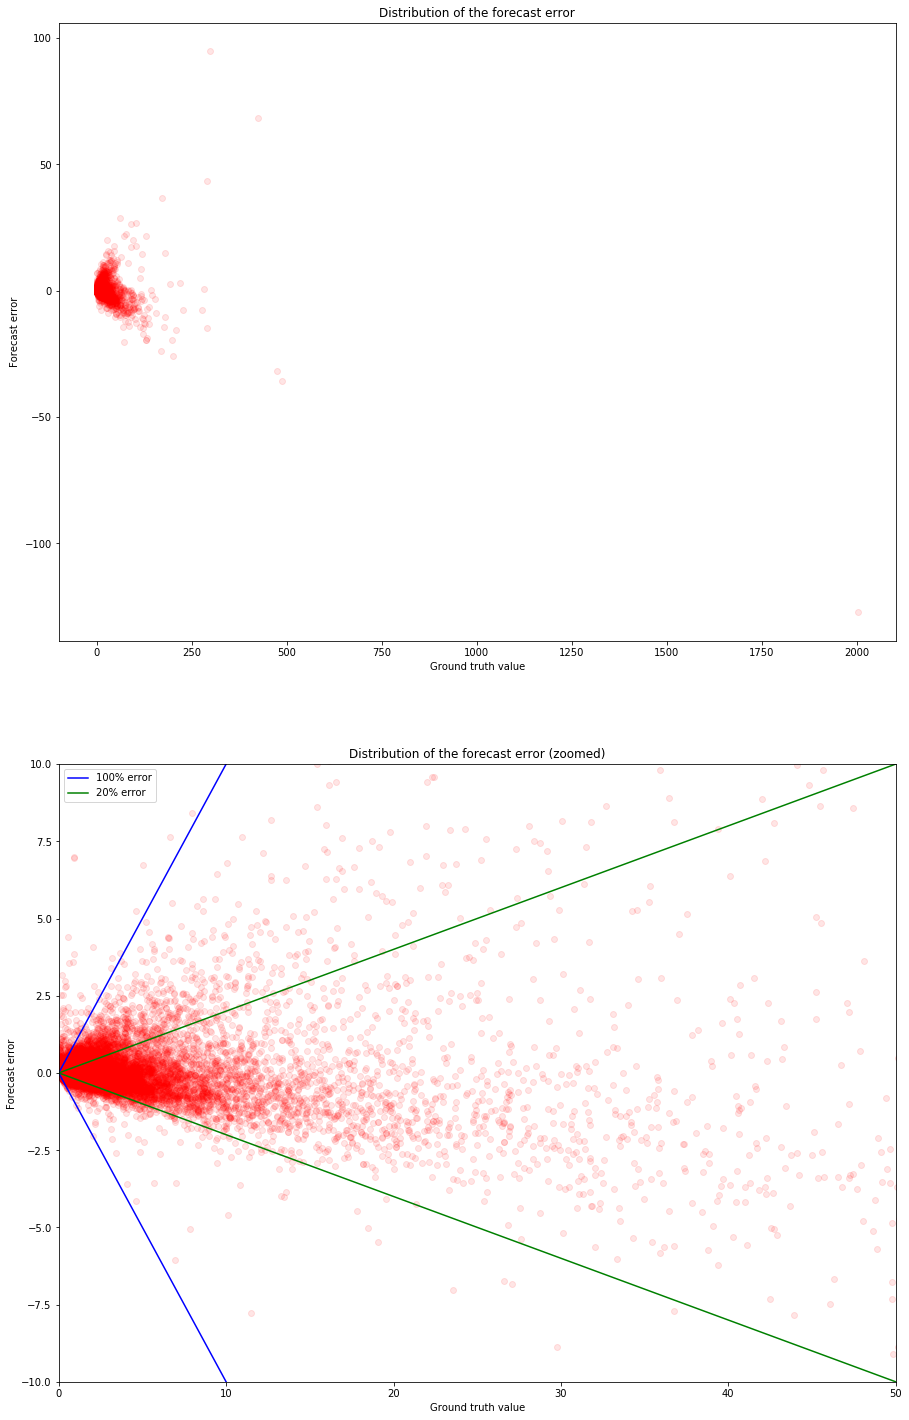

In [23]:
plt.figure(figsize=(15, 25))
plt.subplot(2,1,1)
plt.title('Distribution of the forecast error')
plt.xlabel('Ground truth value')
plt.ylabel('Forecast error')
plt.plot(gt, forecast-gt, 'ro', alpha=0.1)
plt.subplot(2,1,2)
plt.title('Distribution of the forecast error (zoomed)')
plt.xlabel('Ground truth value')
plt.ylabel('Forecast error')
plt.plot(gt, forecast-gt, 'ro', alpha=0.1)
plt.plot([0, 50], [0, 50], '-b', label="100% error")
plt.plot([0, 50], [0, -50], '-b')
plt.plot([0, 50], [0, 10], '-g', label="20% error")
plt.plot([0, 50], [0, -10], '-g')
plt.xlim(0, 50)
plt.ylim(-10, 10)
plt.legend(loc='upper left');

## Demo

Once loaded, you can enter your search queriers (word or several words). To exit gracefully type 'stop'.

If you want to run it after reloading notebook with data already processed, set **preprocess_data=False** and **forecast_data=False** (or only first one if necessary) back at top, that way you can skip unnecessary repetiton of data processing.

In [24]:
spark = SparkSession.builder.\
    master('yarn').\
    appName('scholar').\
    getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

print("Loading...", end='')
df_normed_embeddings = sqlContext.read.format('parquet').load('hdfs:/scholar_data/token_normed_vector_embeddings.parquet').select('entities', 'normed_embeddings')
df_token_freq = sqlContext.read.format('parquet').load('hdfs:/scholar_data/forecast.parquet').select('entities', F.col('forecast').alias('score'))
ftmodel = fasttext.load_model(model_bin_path)
brpLSHmodel = BucketedRandomProjectionLSHModel.load('hdfs:/scholar_model/brpLSH_model')
print("Completed! You can start!")

try:
    neighbors_num = 20
    dist_cutoff = 1
    token = ''
    while token != 'stop':
        token = input()
        token = token.lower()
        if token == 'stop':
            break
        token_vector = norm_np_array(ftmodel[token])

        search_result = brpLSHmodel.approxNearestNeighbors(df_normed_embeddings, token_vector, neighbors_num).select('entities', 'distCol').filter(f'distCol < {dist_cutoff}')
        search_result = search_result.join(df_token_freq, 'entities', how='left')
        search_result = search_result.select('entities', *[F.round(F.col(c), 3).alias(c) for c in ['distCol', 'score']])
        search_result.orderBy('score', ascending=False).show(n=neighbors_num, truncate=False)
except:
    print("Error occured while executing demo loop, stop spark session gracefully")
    
del df_normed_embeddings    
del df_token_freq    
del ftmodel
del brpLSHmodel
    
spark.stop()

Loading...

Completed! You can start!
cancer
+--------------+-------+-------+
|entities      |distCol|score  |
+--------------+-------+-------+
|leukemia      |0.662  |177.398|
|tuberculosis  |0.899  |56.016 |
|lymphoma      |0.707  |47.802 |
|tumor         |0.792  |47.683 |
|chemotherapy  |0.822  |25.986 |
|carcinoma     |0.825  |23.579 |
|adenocarcinoma|0.901  |13.497 |
|melanoma      |0.741  |13.087 |
|lung          |0.884  |11.895 |
|glioblastoma  |0.866  |11.812 |
|disease       |0.766  |10.05  |
|prostate      |0.834  |5.758  |
|neuroblastoma |0.852  |3.763  |
|breast        |0.9    |3.33   |
|osteosarcoma  |0.882  |3.011  |
|mesothelioma  |0.844  |1.097  |
|ovarian       |0.889  |0.568  |
|cancer        |0.0    |0.38   |
|diabetes      |0.859  |0.311  |
|carcinomatosis|0.898  |0.295  |
+--------------+-------+-------+

stop


# Chapter 2: RAKE

## Extra functions

In [14]:
def apply_rake(text, threshold=10.):
    r = Rake()
    r.extract_keywords_from_text(text)
    score_concept_pairs = r.get_ranked_phrases_with_scores()
    concepts = [concept for (score, concept) in score_concept_pairs if score >= threshold]
    return concepts

In [15]:
rake_schema = T.ArrayType(T.StringType(), containsNull=True)
spark_rake = F.udf(lambda text: apply_rake(text), rake_schema)

## Execution

### Preprocessing

In [16]:
if rake_preprocess_data:
    spark = SparkSession.builder.\
        master('local[5]').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    df = sqlContext.read.format('parquet').load('hdfs:/scholar_data/base.parquet')
    df_keyterms = df.filter('paperAbstract!=\'\'').select('id', 'title', 'year', spark_rake('paperAbstract').alias('entities'))
    df_keyterms.write.save('hdfs:/scholar_data/rake_base.parquet', format='parquet', mode='overwrite')

    spark.stop()

In [17]:
if rake_preprocess_data:
    spark = SparkSession.builder.\
        master('yarn').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    # enables cartesian (!) join
    spark.conf.set("spark.sql.crossJoin.enabled", "true")
    spark.conf.set("spark.sql.broadcastTimeout", "1800")

    df = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_base.parquet')
    df_pivoted = pivot_keyterms(df)
    df_pivoted.write.save('hdfs:/scholar_data/rake_tokens_count_by_year.parquet', format='parquet', mode='overwrite')

    spark.stop()

In [18]:
if rake_preprocess_data:
    spark = SparkSession.builder.\
        master('yarn').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    # enables cartesian (!) join
    spark.conf.set("spark.sql.crossJoin.enabled", "true")
    spark.conf.set("spark.sql.broadcastTimeout", "1800")

    df_pivoted = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_tokens_count_by_year.parquet')
    df_token_freq = get_tokens_frequency(df_pivoted)
    df_token_freq.write.save('hdfs:/scholar_data/rake_tokens_freq_by_year.parquet', format='parquet', mode='overwrite')

    spark.stop()

In [19]:
if rake_preprocess_data:
    spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    df_token_freq = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_tokens_freq_by_year.parquet')
    pd_df_entities = df_token_freq.select('entities').toPandas()

    spark.stop()

In [20]:
pd_df_entities.count()

entities    47905
dtype: int64

In [21]:
if rake_preprocess_data:
    pd_df_embeddings = get_embeddings(pd_df_entities)
    pa_df_embeddings = pa.Table.from_pandas(pd_df_embeddings)

    fs = pa.hdfs.connect()
    with fs.open('hdfs:/scholar_data/rake_token_embeddings.parquet', 'wb') as target:
        pq.write_table(pa_df_embeddings, target)

In [23]:
if rake_preprocess_data:
    spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()

    sc = spark.sparkContext
    sqlContext = SQLContext(sc)

    df_embeddings = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_token_embeddings.parquet')
    brpLSHmodel, df_normed_embeddings = fit_lsh_model(df_embeddings)
    brpLSHmodel.write().overwrite().save('hdfs:/scholar_model/rake_brpLSH_model')
    df_normed_embeddings.write.save('hdfs:/scholar_data/rake_token_normed_vector_embeddings.parquet', format='parquet', mode='overwrite')

    spark.stop()

### Forecast

In [24]:
if rake_forecast_data: 
    spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()
    
    sc = spark.sparkContext
    sqlContext = SQLContext(sc)
    
    df_token_freq = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_tokens_freq_by_year.parquet')
    pd_df = df_token_freq.toPandas()
    
    spark.stop()

In [25]:
if rake_forecast_data: 
    import warnings
    warnings.filterwarnings('ignore')
    forecast, forecast_baseline, gt = token_frequency_forecast(pd_df)


Defaulted: 3400/47905


In [26]:
if rake_forecast_data: 
    pd_df_forecast = pd.DataFrame(np.stack((forecast, forecast_baseline, gt), axis=1), columns=['forecast', 'baseline', 'ground_truth'])
    pd_df_forecast['entities'] = pd_df['entities'].to_list()
    
    pa_df_forecast = pa.Table.from_pandas(pd_df_forecast)
    
    fs = pa.hdfs.connect()
    with fs.open('hdfs:/scholar_data/rake_forecast.parquet', 'wb') as target:
        pq.write_table(pa_df_forecast, target)

In [27]:
spark = SparkSession.builder.\
        master('local[2]').\
        appName('scholar').\
        getOrCreate()
    
sc = spark.sparkContext
sqlContext = SQLContext(sc)

df_forecast = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_forecast.parquet')
pd_df_forecast = df_forecast.toPandas()

spark.stop()

In [28]:
baseline = pd_df_forecast['baseline']
forecast = pd_df_forecast['forecast']
gt = pd_df_forecast['ground_truth']

l2_norm_baseline = np.linalg.norm(baseline - gt)
l2_norm_forecast = np.linalg.norm(forecast - gt)

print(f"L-2 norm of baseline error vector: {np.round(l2_norm_baseline, 1)}")
print(f"L-2 norm of forecast error vector: {np.round(l2_norm_forecast, 1)}")

L-2 norm of baseline error vector: 695.4
L-2 norm of forecast error vector: 828.6


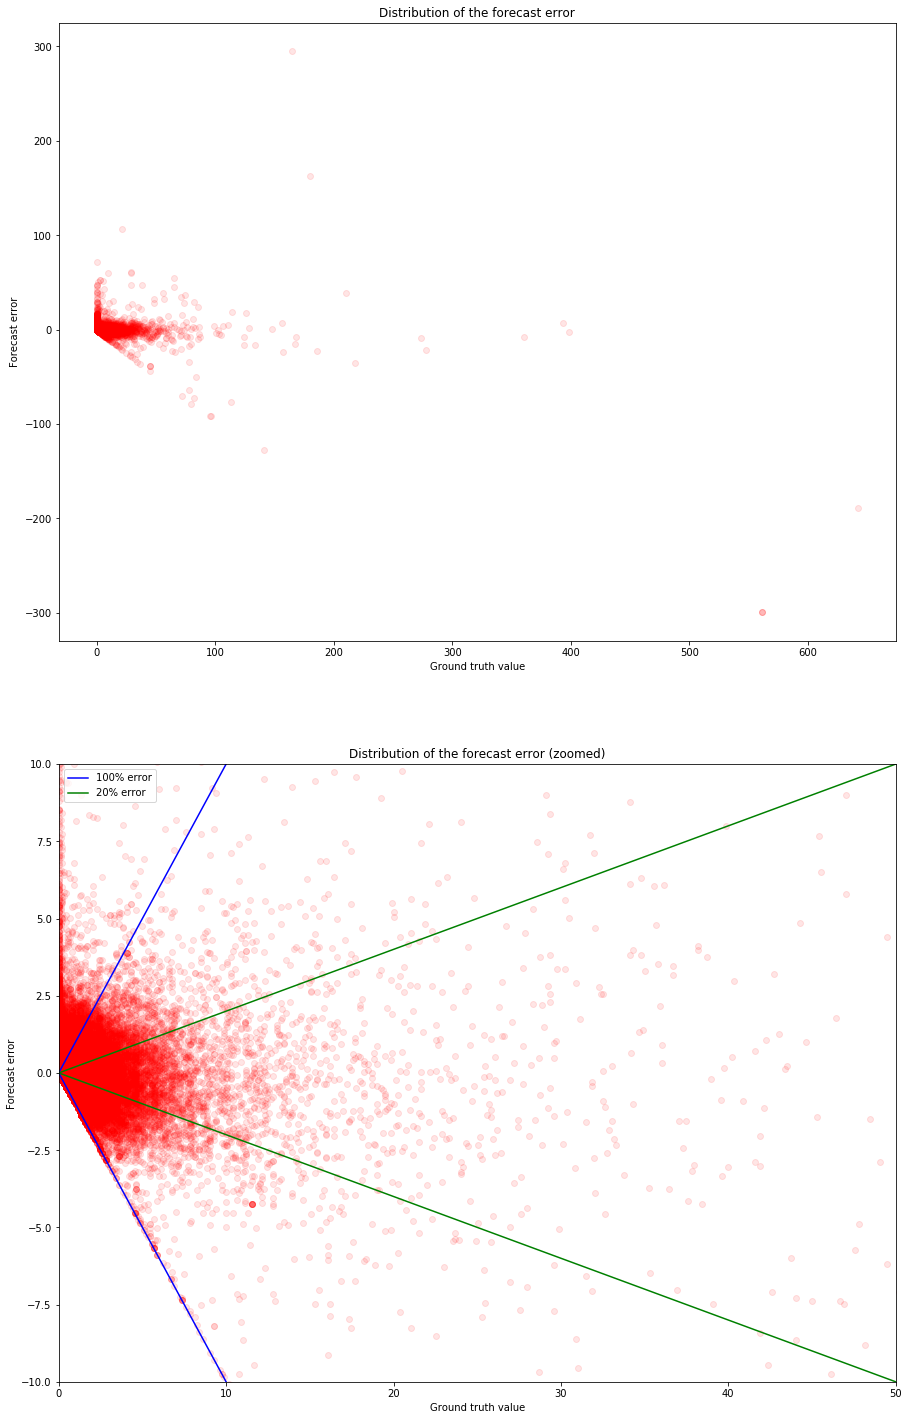

In [29]:
plt.figure(figsize=(15, 25))
plt.subplot(2,1,1)
plt.title('Distribution of the forecast error')
plt.xlabel('Ground truth value')
plt.ylabel('Forecast error')
plt.plot(gt, forecast-gt, 'ro', alpha=0.1)
plt.subplot(2,1,2)
plt.title('Distribution of the forecast error (zoomed)')
plt.xlabel('Ground truth value')
plt.ylabel('Forecast error')
plt.plot(gt, forecast-gt, 'ro', alpha=0.1)
plt.plot([0, 50], [0, 50], '-b', label="100% error")
plt.plot([0, 50], [0, -50], '-b')
plt.plot([0, 50], [0, 10], '-g', label="20% error")
plt.plot([0, 50], [0, -10], '-g')
plt.xlim(0, 50)
plt.ylim(-10, 10)
plt.legend(loc='upper left');

## Demo

In [30]:
spark = SparkSession.builder.\
    master('yarn').\
    appName('scholar').\
    getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

print("Loading...", end='')
df_normed_embeddings = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_token_normed_vector_embeddings.parquet').select('entities', 'normed_embeddings')
df_token_freq = sqlContext.read.format('parquet').load('hdfs:/scholar_data/rake_forecast.parquet').select('entities', F.col('forecast').alias('score'))
ftmodel = fasttext.load_model(model_bin_path)
brpLSHmodel = BucketedRandomProjectionLSHModel.load('hdfs:/scholar_model/rake_brpLSH_model')
print("Completed! You can start!")

try:
    neighbors_num = 20
    dist_cutoff = 1
    token = ''
    while token != 'stop':
        token = input()
        token = token.lower()
        if token == 'stop':
            break
        token_vector = norm_np_array(ftmodel[token])

        search_result = brpLSHmodel.approxNearestNeighbors(df_normed_embeddings, token_vector, neighbors_num).select('entities', 'distCol').filter(f'distCol < {dist_cutoff}')
        search_result = search_result.join(df_token_freq, 'entities', how='left')
        search_result = search_result.select('entities', *[F.round(F.col(c), 3).alias(c) for c in ['distCol', 'score']])
        search_result.orderBy('score', ascending=False).show(n=neighbors_num, truncate=False)
except:
    print("Error occured while executing demo loop, stop spark session gracefully")
    
del df_normed_embeddings    
del df_token_freq    
del ftmodel
del brpLSHmodel
    
spark.stop()

Loading...

Completed! You can start!
cancer
+------------+-------+-----+
|entities    |distCol|score|
+------------+-------+-----+
|diabetes    |0.859  |9.562|
|disease     |0.766  |6.557|
|obesity     |0.914  |5.476|
|cancer      |0.0    |5.404|
|pneumonia   |0.934  |3.285|
|diagnosis   |0.943  |2.576|
|tuberculosis|0.899  |2.18 |
|asthma      |0.941  |1.908|
|chemotherapy|0.822  |1.708|
|radiotherapy|0.937  |1.502|
|tumor       |0.792  |1.315|
|metastasis  |0.835  |1.296|
|breast      |0.9    |1.211|
|prostate    |0.834  |1.198|
|radiation   |0.918  |1.183|
|dementia    |0.906  |1.024|
|melanoma    |0.741  |0.928|
|lung        |0.884  |0.733|
|tumors      |0.785  |0.575|
|diseases    |0.861  |0.426|
+------------+-------+-----+

flue
+--------+-------+-----+
|entities|distCol|score|
+--------+-------+-----+
|gas     |0.992  |0.451|
+--------+-------+-----+

virus
+---------------+-------+-----+
|entities       |distCol|score|
+---------------+-------+-----+
|disease        |0.862  |6.557|
|infe